In [1]:
import music21
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

从 .mid 取得音符🎵

In [2]:
midi_dir = pathlib.Path('./res/')
all_midi_files = midi_dir.glob('*.mid')

all_notes = []
track = 0

for midi_file in all_midi_files:
    midi = music21.converter.parse(midi_file)
    # 使用第一条音轨
    midi = midi[0]
    notes = midi.flat.notes

    # 把和弦转换成 str
    for element in notes:
        if isinstance(element, music21.note.Note):
            all_notes.append(str(element.pitch))
        elif isinstance(element, music21.chord.Chord):
            all_notes.append('.'.join(str(n) for n in element.normalOrder))

vocab = sorted(set(all_notes))
print("vocab's length: ", len(vocab))
print("#notes: ", len(all_notes))
print(all_notes[:30])

vocab's length:  152
#notes:  3098
['C3', 'E-3', 'G#3', 'B-3', 'C4', 'G#3', 'E-4', 'B-4', 'C5', 'G#4', 'E-5', 'B-5', 'C6', 'G5', 'B-5', 'G#5', 'G5', 'F#5', 'F#5', 'G5', 'F#5', 'F5', 'F#5', 'A5', 'G5', 'E-5', 'E-5', 'D5', 'F5', 'E-5']


In [8]:
# 建立 one-hot 词典
note_dict = {}
for i, note in enumerate(vocab):
    note_dict[note] = i

In [9]:
# 输入 50 个音符，输出之后的一个音符
input_notes_length = 50

num_training = len(all_notes) - input_notes_length
input_notes_in_vocab = np.zeros((num_training, input_notes_length, len(vocab)))
output_notes_in_vocab = np.zeros((num_training, len(vocab)))

for i in range(num_training):
    input_notes = all_notes[i: i + input_notes_length]
    output_note = all_notes[i + input_notes_length]
    for j, note in enumerate(input_notes):
        input_notes_in_vocab[i, j, note_dict[note]] = 1
    output_notes_in_vocab[i, note_dict[output_note]] = 1

In [11]:
model = keras.Sequential([
    keras.layers.LSTM(128, return_sequences=True,
                      input_shape=(input_notes_length, len(vocab))),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(vocab), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit(input_notes_in_vocab, output_notes_in_vocab,
                    batch_size=128, epochs=200)

Train on 3048 samples
Epoch 1/200
3048/3048 [==============================] - 8s 2ms/sample - loss: 4.4694 - acc: 0.0433

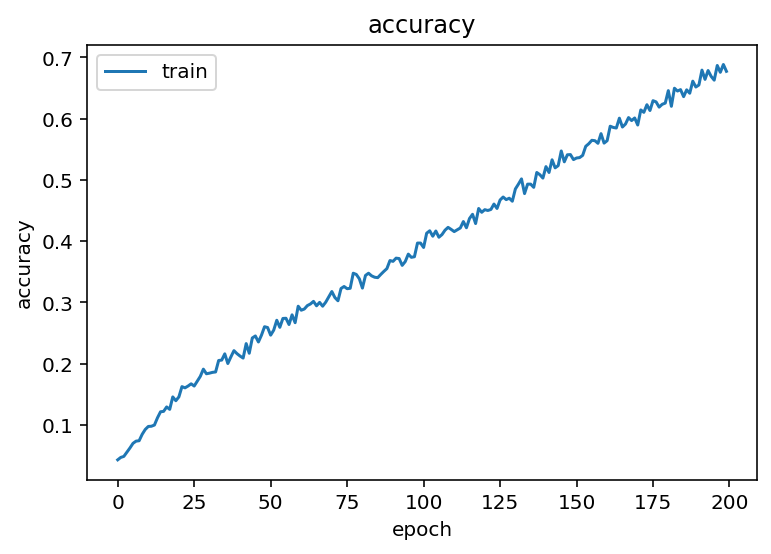

In [12]:
plt.plot(history.history['acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [21]:
# 随机挑选一个序列作为开始
n = np.random.randint(0, len(input_notes_in_vocab) - 1)
random_sequence = input_notes_in_vocab[n]
random_sequence = random_sequence[np.newaxis, :]

In [32]:
sequence = random_sequence
outputs = []
for _ in range(100):
    newNote = model.predict(sequence, verbose=0)
    note_in_vocab = np.argmax(newNote)
    note = np.zeros((len(vocab)))
    note[note_in_vocab] = 1
    outputs.append(note)

    # 序列向前移动
    sequence = sequence[0][1:]
    sequence = np.concatenate((sequence, note[np.newaxis, :]))
    sequence = sequence[np.newaxis, :]

print(len(outputs))
print(outputs[0])

100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


### Convert to MIDI

In [33]:
output_notes = []
for element in outputs:
    note_in_vocab = list(element).index(1)
    output_notes.append(vocab[note_in_vocab])

In [34]:
offset = 0

output_music_notes = []
for note in output_notes:
    # chord
    if ('.' in note) or note.isdigit():
        notes_in_chord = note.split('.')
        notes = []
        for note_in_chord in notes_in_chord:
            one_note = music21.note.Note(int(note_in_chord))
            one_note.storedInstrument = music21.instrument.Piano()
            notes.append(one_note)
        new_chord = music21.chord.Chord(notes)
        new_chord.offset = offset
        output_music_notes.append(new_chord)
    # note
    else:
        new_note = music21.note.Note(note)
        new_note.offset = offset
        new_note.storedInstrument = music21.instrument.Piano()
        output_music_notes.append(new_note)

    # 音符的位置 + 0.5
    offset += 0.5

midi_stream = music21.stream.Stream(output_music_notes)
midi_stream.write('midi', fp='output.mid')

'output.mid'